<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name : Mohammad Parham Bateni
### Student Number : 99105294
___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torchvision.io import read_image

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import glob
from PIL import Image as im
plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [3]:
# run this cell to download and prepare data
from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.head()

efigi_png downloaded!
efigi_tables downloaded!


,name,class_name,class_label
0,PGC0000212,Spirals,2
1,PGC0000218,Spirals,2
2,PGC0000243,Lenticulars,1
3,PGC0000255,Spirals,2
4,PGC0000281,Spirals,2


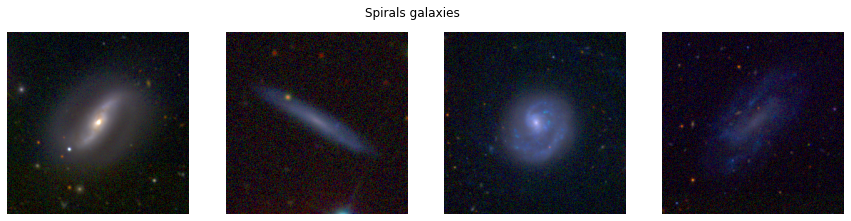

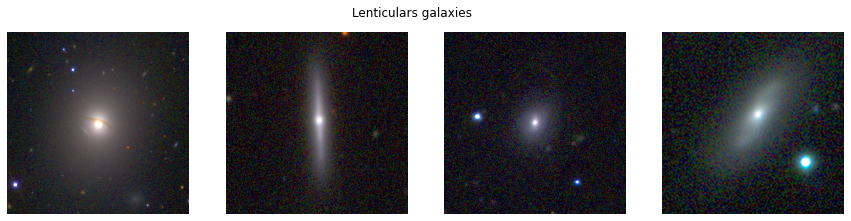

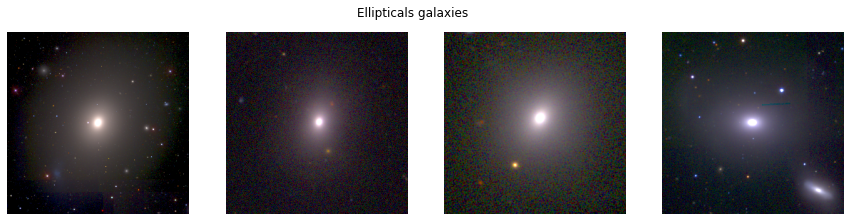

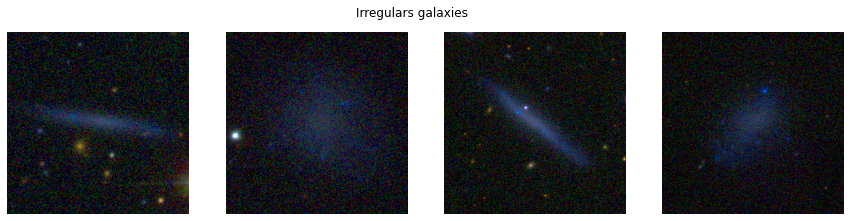

In [4]:
##############################################################
##            Visualize 4 sample from each class            ##
##                        Your Code                         ##
##############################################################
class_names=df['class_name'].unique()
image_shape=None
for class_name in class_names:
  names=np.random.choice(df[df['class_name']==class_name]['name'],4,replace=False)
  fig=plt.figure(figsize=(15,3.75))
  fig.suptitle(f'{class_name} galaxies')
  # fig.tight_layout()
  for i in range(4):
    plt.subplot(1,4,i+1)
    plt.subplots_adjust(top=1, bottom=0.1)
    plt.axis(False)
    image=img.imread(f'./efigi-1.6/png/{names[i]}.png')
    image_shape=image.shape
    plt.imshow(image)

# Define Dataset (20 Points)

In [ ]:
###############################################################
##        Write your dataset class for loading images        ##
##                        Your Code                          ##
###############################################################

# class GalaxyDataSet(Dataset):
#     def __init__(self,annotations_file,img_dir,transform=None,target_transform=None):
#       self.annotations_file=annotations_file
#       self.img_dir=img_dir
#       self.transform=transform
#       self.target_transform=target_transform
#     def __len__(self):
#       return len(self.annotations_file)
#     def __getitem__(self,idx):
#       img_path=os.path.join(self.img_dir,f'{self.annotations_file.iloc[idx,0]}.png')
#       convert_tensor=transforms.ToTensor()
#       image=convert_tensor(im.open(img_path).convert('L'))[0]
#       label=self.annotations_file.iloc[idx,2]
#       if self.transform:
#         self.transform(image)
#       if self.target_transform:
#         self.target_transform(label)
#       return image,label

In [5]:
class GalaxyDataSet(Dataset):
    def __init__(self,images,labels):
      self.images=images
      self.labels=labels
    def __len__(self):
      return len(self.labels)
    def __getitem__(self,idx):
      return self.images[idx],self.labels[idx]

In [6]:
from sklearn.model_selection import train_test_split
test_dataset_size=0.3
images_folder='./efigi-1.6/png'
images=list()
labels=df['class_label'].values.tolist()
convert_tensor=transforms.ToTensor()
for index,row in df.iterrows():
  images.append(convert_tensor(im.open(os.path.join(images_folder,f"{row['name']}.png")))[0])
np.random.seed(11)
X_train,X_test,y_train,y_test=train_test_split(images,labels,test_size=test_dataset_size)

In [7]:
print(len(X_train),len(X_test),len(y_train),len(y_test))

3120 1338 3120 1338


# Define Model (20 Points)

In [10]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################

class ClassifierModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten=nn.Flatten()
    self.linear_tanh_stack=nn.Sequential(
        nn.BatchNorm1d(num_features=255*255),
        nn.Linear(in_features=255*255,out_features=64),
        nn.Tanh(),
        nn.BatchNorm1d(num_features=64),
        nn.Linear(in_features=64,out_features=4),
        nn.Softmax(dim=1)
    )
  
  def forward(self, x):
    x=self.flatten(x)
    logits=self.linear_tanh_stack(x)
    return logits

print(ClassifierModel())

ClassifierModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_tanh_stack): Sequential(
    (0): BatchNorm1d(65025, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=65025, out_features=64, bias=True)
    (2): Tanh()
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=64, out_features=4, bias=True)
    (5): Softmax(dim=1)
  )
)


# Train Model (30 Points)

In [11]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function ant etc                                     ##
######################################################################
#helpful links :))
#https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
#https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
#https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

batch_size=64
learning_rate=0.0001
epochs=30

train_dataloader=DataLoader(GalaxyDataSet(X_train,y_train),batch_size=batch_size)
test_dataloader=DataLoader(GalaxyDataSet(X_test,y_test),batch_size=batch_size)

model=ClassifierModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss=list()
train_accuracy=list()
for epoch in range(epochs):
  size=len(train_dataloader.dataset)
  model.train()
  num_correct=0
  for batch,(X,y) in enumerate(train_dataloader):
    with torch.set_grad_enabled(True):
      X,y=X.to(device).float(),y.to(device)
      pred=model(X)
      loss=criterion(pred,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      num_correct+=(pred.argmax(1)==y).sum().item()
  train_loss.append(loss.item())
  train_accuracy.append(num_correct/size)
  print(f"Epoch {epoch+1}\t loss: {loss.item()}\t accuracy: {num_correct/size}\n-------------------------------")


Epoch 1	 loss: 1.142269253730774	 accuracy: 0.5842948717948718
-------------------------------
Epoch 2	 loss: 1.0947442054748535	 accuracy: 0.6596153846153846
-------------------------------
Epoch 3	 loss: 1.0808955430984497	 accuracy: 0.6865384615384615
-------------------------------
Epoch 4	 loss: 1.0433908700942993	 accuracy: 0.708974358974359
-------------------------------
Epoch 5	 loss: 1.0166468620300293	 accuracy: 0.7432692307692308
-------------------------------
Epoch 6	 loss: 1.000826358795166	 accuracy: 0.7810897435897436
-------------------------------
Epoch 7	 loss: 0.968463122844696	 accuracy: 0.8137820512820513
-------------------------------
Epoch 8	 loss: 0.955589771270752	 accuracy: 0.8355769230769231
-------------------------------
Epoch 9	 loss: 0.9416897892951965	 accuracy: 0.8519230769230769
-------------------------------
Epoch 10	 loss: 0.9366043210029602	 accuracy: 0.8650641025641026
-------------------------------
Epoch 11	 loss: 0.933329164981842	 accuracy:

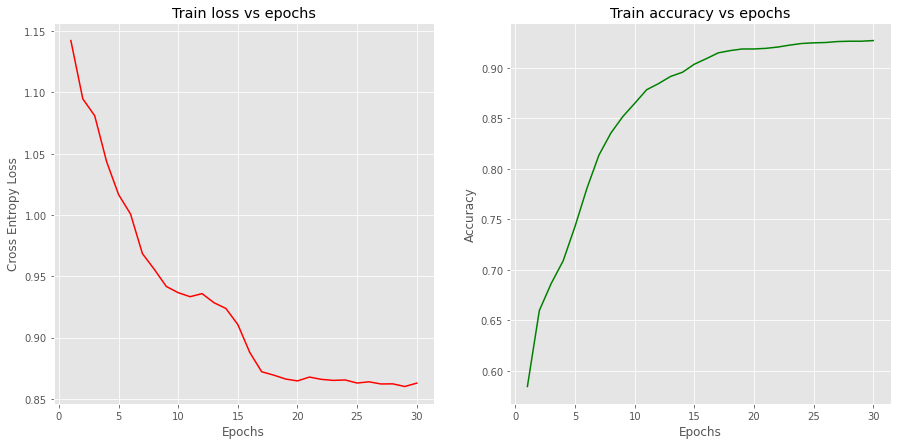

In [12]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,7))
ax1.set_title('Train loss vs epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cross Entropy Loss')
ax1.plot(np.arange(1,epochs+1),train_loss,color='red')
ax2.set_title('Train accuracy vs epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.plot(np.arange(1,epochs+1),train_accuracy,color='green')
plt.show()

# Test Model (20)

Test loss: 1.0279992762066068
Test: F1-score: 0.39084636788098825


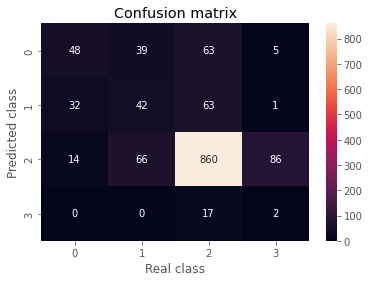

In [19]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################
import seaborn as sns
from sklearn.metrics import f1_score
test_loss,correct=0,0
confusion_matrix=[[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]

with torch.no_grad():
  model.eval()
  predicts=list()
  ys=list()
  for batch,(X,y) in enumerate(test_dataloader):
    X,y=X.to(device),y.to(device)
    pred=model(X)
    loss=criterion(pred,y)
    test_loss+=loss.item()
    correct+=(pred.argmax(1)==y).type(torch.float).sum().item()
    for i in range(pred.shape[0]):
      confusion_matrix[pred[i].argmax().item()][y[i]]+=1
      predicts.append(pred[i].argmax().item())
    ys.extend(y.tolist())
  print(f'Test loss: {test_loss/len(test_dataloader)}')
  print(f"Test: F1-score: {f1_score(ys,predicts,average='macro')}")
ax=sns.heatmap(confusion_matrix,annot=True,fmt='g')
ax.set_title('Confusion matrix')
ax.set_xlabel('Real class')
ax.set_ylabel('Predicted class')
plt.show()